<a href="https://colab.research.google.com/github/DutchVandaline/Artificial_Intelligence/blob/main/YOLO_v1_self_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building YOLO v1
I am studying PyTorch and Computer Vision. I know how to make CNN, TinyVGG. I have some convidence to make other Computer Vision model and I started with YOLO v1. YOLO, which stands for *You Only Look Once* is a fast model but, heavy to run on colab. So, I decided to make one by myself using the following Image!

This is the paper url of YOLO : https://arxiv.org/abs/1506.02640



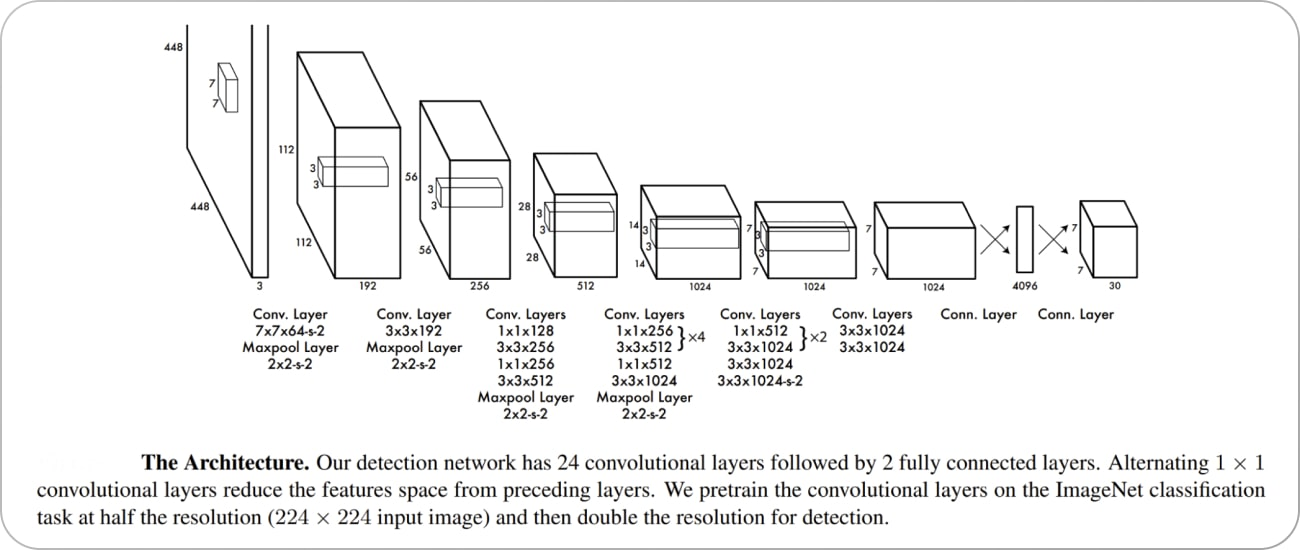


### 1. Setting up the basics
I've used data of *Pizza-Steak-Sushi* from mrdbourke. Data is at following url : https://github.com/mrdbourke/pytorch-deep-learning/tree/main/data

* 225 training sets
* 75 test sets

In [1]:
import torch
import torch.nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)

2.4.1+cu121


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} director yalready exists... skipping download")
else:
  print(f"{image_path} doesn't exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  # the file needs to be raw not blob
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, suchi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exist, creating one...
Unzipping pizza, steak and sushi data...


In [4]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its conents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directoreis and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)


There are 2 directoreis and 0 images in 'data/pizza_steak_sushi'.
There are 3 directoreis and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directoreis and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directoreis and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directoreis and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directoreis and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directoreis and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directoreis and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directoreis and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/steak/1976160.jpg
Image class: steak
Image height: 512
iamge width : 512


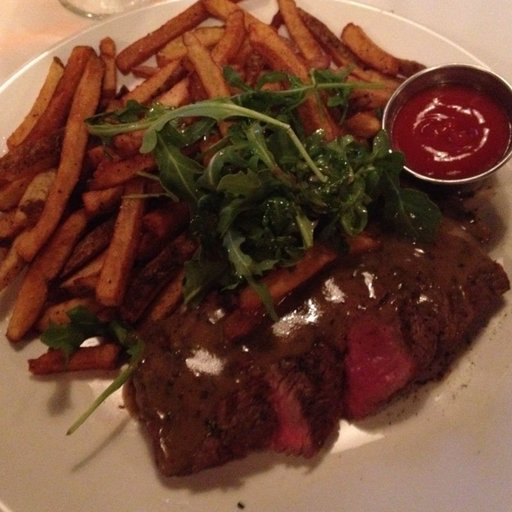

In [6]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths()
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the iamge is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"iamge width : {img.width}")
img

In [7]:
import requests
from pathlib import Path

#Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper function.py already exiss")
else:
  print("Downloading helper function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

(-0.5, 511.5, 511.5, -0.5)

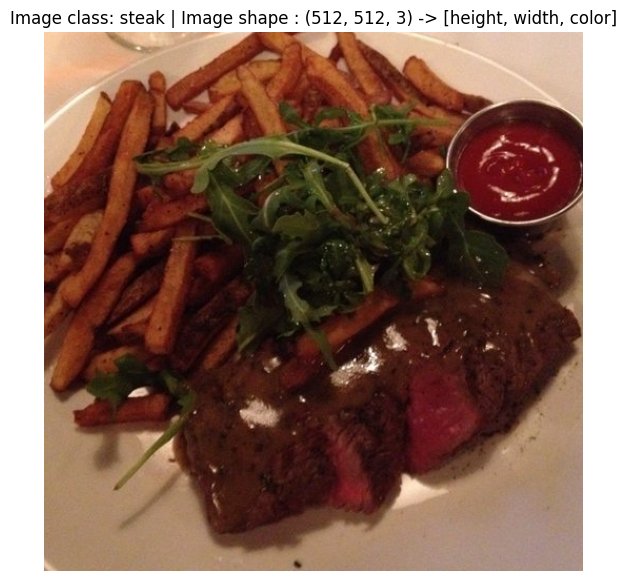

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape : {img_as_array.shape} -> [height, width, color]")
plt.axis(False)

## 2. Making input image match
YOLO accepts 448 * 448 image files for the input so, I have to transform the image size.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 448 * 448
    transforms.Resize(size=(448, 448)),
    # Turn the image into torch.Tensor
    transforms.ToTensor()
])

data_transform(img)

tensor([[[0.9882, 0.9765, 0.9725,  ..., 0.8784, 0.8784, 0.8980],
         [0.9843, 0.9765, 0.9725,  ..., 0.8902, 0.8902, 0.8863],
         [0.9804, 0.9765, 0.9765,  ..., 0.8980, 0.8941, 0.8824],
         ...,
         [0.7451, 0.8039, 0.8588,  ..., 0.6784, 0.6824, 0.6667],
         [0.6902, 0.7373, 0.8039,  ..., 0.6824, 0.6824, 0.6706],
         [0.6706, 0.6941, 0.7490,  ..., 0.6902, 0.6824, 0.6863]],

        [[0.8196, 0.8078, 0.8039,  ..., 0.7725, 0.7725, 0.7922],
         [0.8157, 0.8078, 0.8039,  ..., 0.7843, 0.7843, 0.7804],
         [0.8118, 0.8078, 0.8078,  ..., 0.7922, 0.7882, 0.7765],
         ...,
         [0.6078, 0.6667, 0.7216,  ..., 0.5725, 0.5804, 0.5647],
         [0.5529, 0.6000, 0.6667,  ..., 0.5765, 0.5804, 0.5686],
         [0.5333, 0.5569, 0.6118,  ..., 0.5882, 0.5804, 0.5843]],

        [[0.6549, 0.6431, 0.6392,  ..., 0.7059, 0.7059, 0.7255],
         [0.6510, 0.6431, 0.6392,  ..., 0.7137, 0.7137, 0.7137],
         [0.6471, 0.6431, 0.6431,  ..., 0.7176, 0.7137, 0.

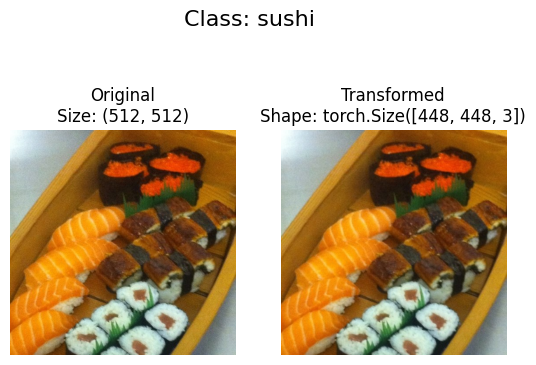

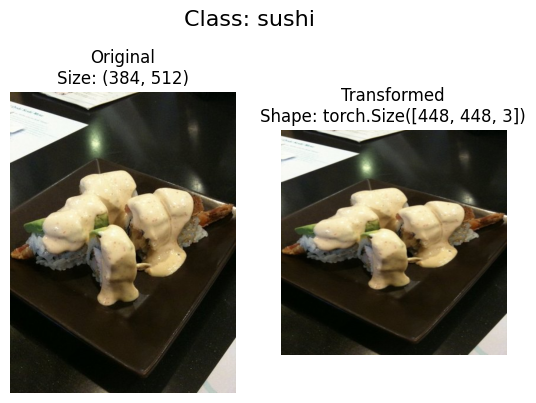

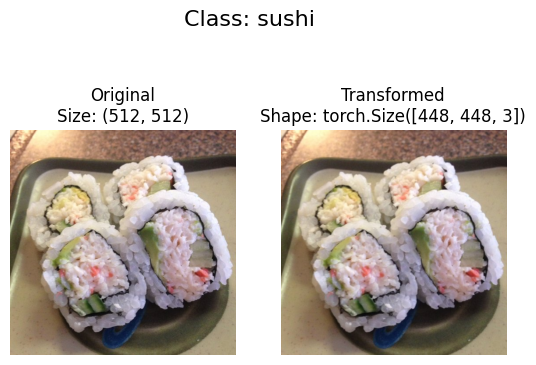

In [10]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform an plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)


In [11]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

class_names = train_data.classes
train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(448, 448), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(448, 448), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

# Get class name as dict
class_dict = train_data.class_to_idx
class_dict

# Chcek the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [13]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
CPU_COUNT = os.cpu_count()

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = CPU_COUNT,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = CPU_COUNT,
                             shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ca824bcc790>,
 <torch.utils.data.dataloader.DataLoader at 0x7ca824bcc8b0>)

### 3. Building Model

In [14]:
from torch import nn
import torch.nn.functional as F

class YOLOV1(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size= 7,stride=2,padding=3),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,out_channels = 192 ,kernel_size = 3,padding=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
    )

    self.block_3 = nn.Sequential(
        nn.Conv2d(in_channels = 192,out_channels = 128,kernel_size = 1,padding = 0),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1,),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256,out_channels = 256,kernel_size = 1,padding = 0),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size = 3,padding = 1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size =2,stride = 2)
    )

    self.block_4 = nn.Sequential(
    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=0),
    nn.LeakyReLU(),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
    nn.LeakyReLU(),

    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=0),
    nn.LeakyReLU(),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
    nn.LeakyReLU(),

    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=0),
    nn.LeakyReLU(),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
    nn.LeakyReLU(),

    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=0),
    nn.LeakyReLU(),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
    nn.LeakyReLU(),

    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0),
    nn.LeakyReLU(),

    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2)
)


    self.block_5 = nn.Sequential(
      nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0),
      nn.LeakyReLU(),
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
      nn.LeakyReLU(),

      nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0),
      nn.LeakyReLU(),
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
      nn.LeakyReLU(),

      nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
      nn.LeakyReLU(),

      nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, stride=2),
      nn.LeakyReLU(),
  )
    self.block_6 = nn.Sequential(
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=0,),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,),
        nn.LeakyReLU(),
    )

    self.flatten = nn.Flatten()

    self.block_7 = nn.Linear(in_features=1024 * 5 * 5, out_features=4096)

    self.block_8 = nn.Linear(in_features=4096, out_features=output_shape)




  def forward(self, x:torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    x = self.block_5(x)
    x = self.block_6(x)

    x = self.flatten(x)

    x = self.block_7(x)
    x = self.block_8(x)

    # x = F.softmax(x, dim=1)

    return x



In [15]:
model_0 = YOLOV1(input_shape=3,
                 hidden_units=64,
                 output_shape=len(class_names)).to(device)
model_0

YOLOV1(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

### Loss Function for YOLO

This is the part where I've been struggling for. I've used Loss function of `nn.CrossEntropyError()` but, the values exploded. I've looked up for the paper to see what the problem is and found that YOLO has it's own Loss function. Following image is the loss function of YOLO.

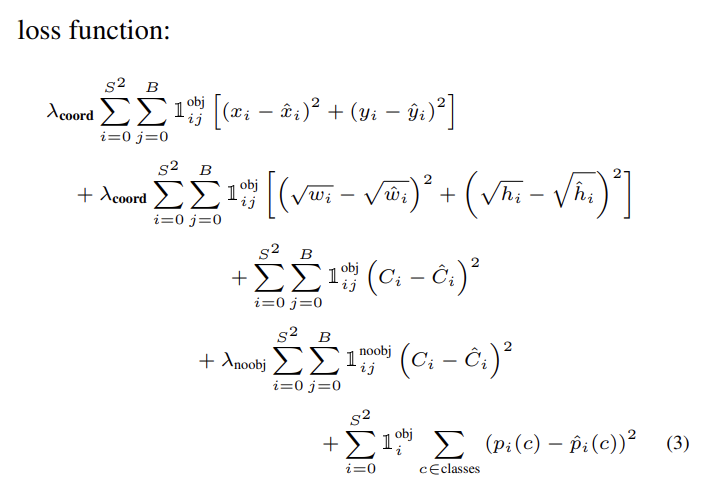

In [19]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = YoloLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(), lr=0.01)

In [20]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0

  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    # print(f"y_pred : {y_pred}")
    # print(f"y : {y}")
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss:.5f} | Train acc : {train_acc: .2f}%")


In [21]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}% \n")

In [22]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
from timeit import default_timer as timer

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_cpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")
  train_step(model=model_0,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn=accuracy_fn,
             device = device)

  test_step(model=model_0,
             data_loader = test_dataloader,
             loss_fn = loss_fn,
             accuracy_fn=accuracy_fn,
             device = device)

train_time_end_on_cpu = timer()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----


RuntimeError: shape '[-1, 7, 7, 30]' is invalid for input of size 96